In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [8]:
!kaggle datasets download -d jhislainematchouath/soil-types-dataset

 89% 177M/198M [00:01<00:00, 152MB/s]
100% 198M/198M [00:01<00:00, 137MB/s]


In [9]:
import zipfile
zip_ref = zipfile.ZipFile('/content/soil-types-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [27]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
import os


In [28]:
BATCH_SIZE=16
IMG_SIZE = (224, 224)

In [29]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/Dataset/Train',
    label_mode = 'categorical',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

val_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/Dataset/test',
    label_mode = 'categorical',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 1215 files belonging to 4 classes.
Found 340 files belonging to 4 classes.


In [30]:
class_names = tuple(train_ds.class_names)
class_names



('Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil')

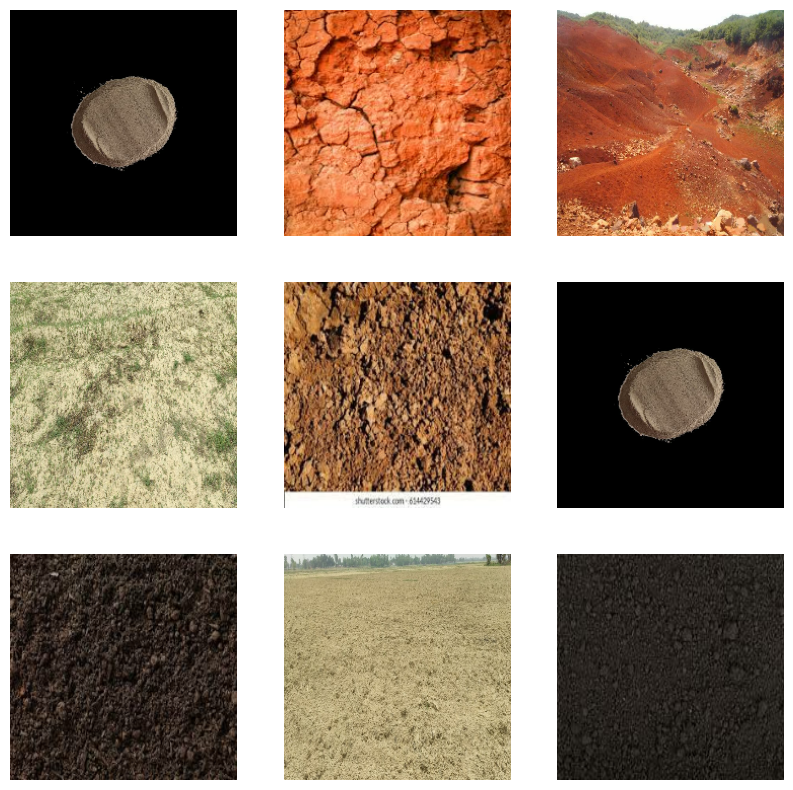

In [ ]:
#Visualisation de quelques images du dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
        plt.axis("off")

In [31]:
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
    preprocessing_model.add(
      tf.keras.layers.RandomRotation(20))
    preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
    preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
    preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_data = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))


valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
validation_datat = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

In [32]:
for image_batch, label_batch in train_ds:
    break
image_batch.shape, label_batch.shape

(TensorShape([16, 224, 224, 3]), TensorShape([16, 4]))

In [33]:
model_handle="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMG_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=False),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.build((None,)+IMG_SIZE+(3,))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              3540265   
                                                                 
 dense_1 (Dense)             (None, 4)                 4008      
                                                                 
Total params: 3544273 (13.52 MB)
Trainable params: 4008 (15.66 KB)
Non-trainable params: 3540265 (13.51 MB)
_________________________________________________________________


In [36]:
model.compile(
  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

In [37]:
history = model.fit(train_data,
          validation_data=validation_datat,
          epochs=30,
          steps_per_epoch=train_size,
          validation_steps= valid_size
         )

Epoch 1/3
76/76 [==============================] - 38s 434ms/step - loss: 1.5156 - accuracy: 0.4370 - val_loss: 1.3588 - val_accuracy: 0.4706
Epoch 2/3
76/76 [==============================] - 29s 391ms/step - loss: 1.0207 - accuracy: 0.6140 - val_loss: 1.1446 - val_accuracy: 0.5647
Epoch 3/3
76/76 [==============================] - 29s 385ms/step - loss: 0.8099 - accuracy: 0.7004 - val_loss: 0.9928 - val_accuracy: 0.6324


In [ ]:
do_fine_tuning = True
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMG_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.build((None,)+IMG_SIZE+(3,))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              3540265   
                                                                 
 dense_1 (Dense)             (None, 4)                 4008      
                                                                 
Total params: 3544273 (13.52 MB)
Trainable params: 3510161 (13.39 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


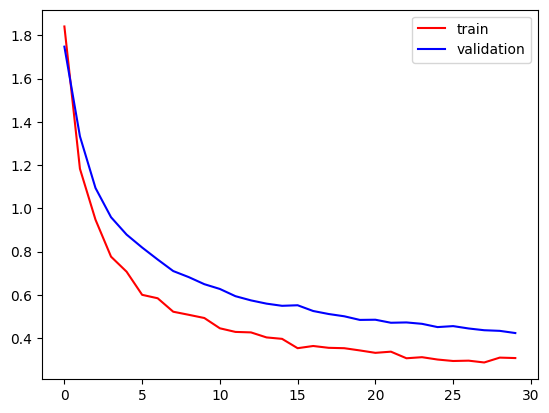

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

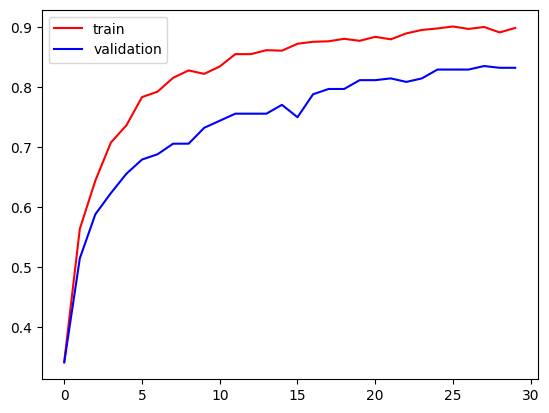

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy']
              # steps_per_epoch=150
               )

In [ ]:
fine_tune_epochs = 30
initial_epochs =30
total_epochs =  initial_epochs + fine_tune_epochs

In [ ]:
history_fine = model.fit(train_data,
                        validation_data=validation_datat,
                          steps_per_epoch=train_size,
                          validation_steps= valid_size,
                        epochs=total_epochs,
                        initial_epoch =  history.epoch[-1]
                        )

Epoch 30/60
76/76 [==============================] - 60s 415ms/step - loss: 1.4997 - accuracy: 0.4765 - val_loss: 1.5988 - val_accuracy: 0.4971
Epoch 31/60
76/76 [==============================] - 30s 403ms/step - loss: 0.9200 - accuracy: 0.7029 - val_loss: 1.1253 - val_accuracy: 0.6647
Epoch 32/60
76/76 [==============================] - 31s 407ms/step - loss: 0.7338 - accuracy: 0.7778 - val_loss: 0.8594 - val_accuracy: 0.7471
Epoch 33/60
76/76 [==============================] - 29s 390ms/step - loss: 0.6676 - accuracy: 0.7967 - val_loss: 0.7788 - val_accuracy: 0.7471
Epoch 34/60
76/76 [==============================] - 30s 401ms/step - loss: 0.6270 - accuracy: 0.8074 - val_loss: 0.7602 - val_accuracy: 0.7500
Epoch 35/60
76/76 [==============================] - 29s 391ms/step - loss: 0.5668 - accuracy: 0.8420 - val_loss: 0.7140 - val_accuracy: 0.7765
Epoch 36/60
76/76 [==============================] - 31s 409ms/step - loss: 0.5249 - accuracy: 0.8551 - val_loss: 0.7280 - val_accuracy:

In [40]:
model.save("/content/soil1.keras")



In [41]:
from google.colab import files
files.download("/content/soil1.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
model.save("/content/soil.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
new_model = tf.keras.models.load_model('soil.keras', custom_objects={'KerasLayer':hub.KerasLayer})

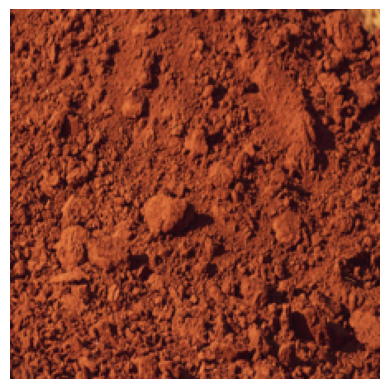

1/1 [==============================] - 0s 24ms/step
Predicted label: Red soil


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load your custom image
custom_image = Image.open("/content/test_img1.jpg")  # Replace "path/to/your/image.jpg" with the path to your image file
custom_image = custom_image.resize((224, 224))  # Resize the image to match the input size of your model
custom_image_array = np.array(custom_image) / 255.0  # Normalize the image pixel values

# Display the custom image
plt.imshow(custom_image)
plt.axis('off')
plt.show()

# Expand the custom image to (1, 224, 224, 3) before predicting the label
custom_image_array = np.expand_dims(custom_image_array, axis=0)

# Predict the label for the custom image
prediction_scores = new_model.predict(custom_image_array)
predicted_index = np.argmax(prediction_scores)

# Print the true and predicted labels
print("Predicted label: " + class_names[predicted_index])